In [ ]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import log_loss
import shap

import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

configuration = cfbd.Configuration(
    access_token = os.environ.get("CFBD_API_KEY")
)

In [2]:
import glob

parquet_files = glob.glob('results/*.parquet')
df = pd.concat([pd.read_parquet(file) for file in parquet_files], ignore_index=True)

In [3]:
# recommendation is max of exp_wp_go, exp_wp_punt, exp_wp_fg
df['recommendation'] = np.select(
    [
        (df['exp_wp_go'] >= df['exp_wp_punt']) & (df['exp_wp_go'] >= df['exp_wp_fg']),
        (df['exp_wp_punt'] >= df['exp_wp_go']) & (df['exp_wp_punt'] >= df['exp_wp_fg']),
        (df['exp_wp_fg'] >= df['exp_wp_go']) & (df['exp_wp_fg'] >= df['exp_wp_punt']),
    ],
    [
        'go',
        'punt',
        'fg',
    ],
    default=np.nan
)

In [4]:
df.recommendation.value_counts(normalize=True)

recommendation
punt    0.396335
go      0.393734
fg      0.209931
Name: proportion, dtype: float64

In [5]:
df.head()

,season,week,season_type,start_date,game_id,play_id,offense,offense_division,offense_timeouts,offense_score,offense_strength,pregame_offense_elo,defense,defense_division,defense_timeouts,defense_score,defense_strength,pregame_defense_elo,period,clock_minutes,clock_seconds,pct_game_played,pct_half_played,game_seconds_remaining,seconds_left_in_half,seconds_after_kneelout,can_kneel_out,can_kneel_out_30,can_kneel_out_60,can_kneel_out_90,play_type,play_text,score_diff,pregame_elo_diff,pregame_spread,diff_time_ratio,spread_time_ratio,yards_to_goal,down,distance,home_id,home_team,home_conference,away_id,away_team,away_conference,is_home_team,home_division,home_pregame_elo,away_division,away_pregame_elo,precipitation,elevation,grass,wind_speed,temperature,game_indoors,pressure_rating,fg_make_proba,wp_make_proba,wp_miss_proba,receiving_team_yards_to_goal,fourth_down_conversion_proba,wp_convert_proba,wp_fail_proba,action,decision,exp_wp_fg,exp_wp_go,exp_wp_punt,recommendation
0,2016,15,regular,2016-12-10 20:00:00+00:00,400868921,400868921102918401,Army,fbs,3,7,-0.034049,1473.570895,Navy,fbs,3,0,-0.119383,2292.009082,2,8,15,0.362500,0.362500,2295,495.0,2295,0,0,0,0,Rush,Andy Davidson run for 3 yds to the Navy 12 for...,7,-818.438186,11.5,29.841802,2.697558,15,4,2,349,Army,FBS Independents,2426,Navy,American Athletic,0,fbs,1473.570895,fbs,2292.009082,0.0,2.961556,0,17.2,35.1,0,0,0.775686,0.4325,0.3748,88.000000,0.565920,0.4696,0.3748,rush,go,0.4196,0.4284,0.3748,go
1,2016,15,regular,2016-12-10 20:00:00+00:00,400868921,400868921103908001,Army,fbs,3,14,-0.034049,1473.570895,Navy,fbs,2,7,-0.119383,2292.009082,3,9,19,0.594722,0.094722,1459,1459.0,1459,0,0,0,0,Punt,"J.D. Mote punt for 30 yds, downed at the Navy 35",7,-818.438186,11.5,75.550329,1.065515,65,4,3,349,Army,FBS Independents,2426,Navy,American Athletic,0,fbs,1473.570895,fbs,2292.009082,0.0,2.961556,0,17.2,35.1,0,0,0.000000,0.5885,0.4203,74.133133,0.526110,0.5866,0.4203,punt,punt,0.4203,0.5078,0.4984,go
2,2016,15,regular,2016-12-10 20:00:00+00:00,400868921,400868921104867001,Army,fbs,3,14,-0.034049,1473.570895,Navy,fbs,1,10,-0.119383,2292.009082,4,13,29,0.775278,0.275278,809,809.0,809,0,0,0,0,Punt,"J.D. Mote punt for 25 yds, downed at the Navy 47",4,-818.438186,11.5,88.890518,0.517491,72,4,3,349,Army,FBS Independents,2426,Navy,American Athletic,0,fbs,1473.570895,fbs,2292.009082,0.0,2.961556,0,17.2,35.1,0,0,0.000000,0.6540,0.3543,68.926595,0.529419,0.5524,0.3543,punt,punt,0.3543,0.4592,0.4422,go
3,2016,15,regular,2016-12-10 20:00:00+00:00,400868921,400868921104934401,Army,fbs,3,14,-0.034049,1473.570895,Navy,fbs,1,17,-0.119383,2292.009082,4,6,55,0.884722,0.384722,415,415.0,415,0,0,0,0,Rush,Andy Davidson run for 7 yds to the Navy 11 for...,-3,-818.438186,11.5,-103.285932,0.334024,18,4,1,349,Army,FBS Independents,2426,Navy,American Athletic,0,fbs,1473.570895,fbs,2292.009082,0.0,2.961556,0,17.2,35.1,0,2,0.573597,0.2695,0.1400,88.000000,0.689359,0.3426,0.1400,rush,go,0.2143,0.2797,0.1526,go
4,2016,15,regular,2016-12-10 20:00:00+00:00,400868921,400868921102867201,Navy,fbs,3,0,0.222590,2292.009082,Army,fbs,3,7,-0.173330,1473.570895,2,13,27,0.275833,0.275833,2607,807.0,2607,0,0,0,0,Punt,"Alex Barta punt for 15 yds, punt out-of-bounds...",-7,818.438186,-11.5,-21.099376,-3.815279,69,4,1,349,Army,FBS Independents,2426,Navy,American Athletic,0,fbs,1473.570895,fbs,2292.009082,0.0,2.961556,0,17.2,35.1,0,0,0.000000,0.7047,0.5566,73.328364,0.759116,0.6277,0.5566,punt,punt,0.5566,0.6106,0.6126,punt


In [203]:
df.decision.value_counts(normalize=True)

decision
punt          0.586911
go            0.224487
field_goal    0.188603
Name: proportion, dtype: float64

<Axes: >

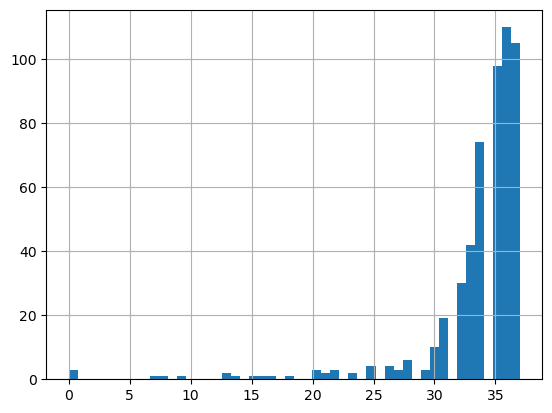

In [209]:
df.assign(
    eWP_diff_punt_fg = np.abs(df['exp_wp_punt'] - df['exp_wp_fg']),
).query('recommendation == "fg" and decision == "punt" and eWP_diff_punt_fg >= .005').yards_to_goal.hist(bins=50)

In [206]:
df.query('recommendation == "fg" and decision != "field_goal" and yards_to_goal >= 45')[
    ['play_id','season','week','season_type','offense','defense','exp_wp_go', 'exp_wp_punt', 'exp_wp_fg','pregame_spread','yards_to_goal',
     'distance','score_diff','pct_game_played','fg_make_proba', 'fg_make_proba', 'wp_make_proba',
       'wp_miss_proba','wp_convert_proba', 'wp_fail_proba','receiving_team_yards_to_goal','pregame_elo_diff']].head()

,play_id,season,week,season_type,offense,defense,exp_wp_go,exp_wp_punt,exp_wp_fg,pregame_spread,yards_to_goal,distance,score_diff,pct_game_played,fg_make_proba,fg_make_proba,wp_make_proba,wp_miss_proba,wp_convert_proba,wp_fail_proba,receiving_team_yards_to_goal,pregame_elo_diff
248,400763404104897006,2015,1,regular,Akron,Oklahoma,0.0002,0.0002,0.0002,38.0,83,9,-38,0.825278,0.0,0.0,0.0003,0.0002,0.0002,0.0002,60.687909,-1593.162969
474,400756899104878301,2015,1,regular,Texas State,Florida State,0.0001,0.0001,0.0001,37.0,70,5,-32,0.795556,0.0,0.0,0.0001,0.0001,0.0001,0.0001,70.922560,-1860.435168
476,400756899104988901,2015,1,regular,Texas State,Florida State,0.0001,0.0001,0.0001,37.0,66,1,-43,0.980556,0.0,0.0,0.0002,0.0001,0.0001,0.0001,73.800564,-1860.435168
932,400933893104895301,2017,8,regular,Tennessee,Alabama,0.0001,0.0001,0.0001,36.5,75,10,-31,0.820556,0.0,0.0,0.0002,0.0001,0.0002,0.0001,67.885712,-1163.039600
991,400934532104896404,2017,8,regular,Kansas,TCU,0.0002,0.0002,0.0002,37.5,80,2,-43,0.823611,0.0,0.0,0.0003,0.0002,0.0003,0.0002,62.632225,-1627.548923


In [ ]:
cols = ['season', 'week', 'season_type', 'play_id',
        'offense', 'offense_score', 'offense_timeouts', 'pregame_offense_elo', 'offense_strength',
        'defense', 'defense_score', 'defense_timeouts', 'pregame_defense_elo', 'defense_strength',
        'period', 'clock_minutes', 'clock_seconds', 'seconds_left_in_half',
       'yards_to_goal', 'distance',  
       'diff_time_ratio', 'spread_time_ratio', 
       'seconds_after_kneelout', 'seconds_after_punt_and_opponent_kneelout', 'can_kneel_out',
       'can_kneel_out_30', 'can_kneel_out_60', 'can_kneel_out_90', 
       'fg_make_proba', 'wp_make_proba',
       'wp_miss_proba',  'receiving_team_yards_to_goal',
        'fourth_down_conversion_proba',
       'wp_convert_proba', 'wp_fail_proba', 'exp_wp_punt','exp_wp_fg', 'exp_wp_go',
       'play_text', 'action', 'decision', 'recommendation']
df.query('60 <= seconds_left_in_half and seconds_left_in_half <= 120 and period == 4 and -16 <= score_diff and score_diff <= -1 and offense_timeouts == 0 and recommendation != "go"')[cols].to_dict('records')
# df.query('120 <= seconds_left_in_half and seconds_left_in_half <= 180 and period == 4 and offense_timeouts == 0')[cols].to_dict('records')

[{'season': 2025,
  'week': 2,
  'season_type': 'regular',
  'play_id': 401762458104988901,
  'offense': 'UAB',
  'offense_score': 24,
  'offense_timeouts': 0,
  'pregame_offense_elo': 1562.0086784946138,
  'offense_strength': 0.1264010794306185,
  'defense': 'Navy',
  'defense_score': 38,
  'defense_timeouts': 2,
  'pregame_defense_elo': 2168.020463557263,
  'defense_strength': 0.1596048534495371,
  'period': 4,
  'clock_minutes': 1,
  'clock_seconds': 10,
  'seconds_left_in_half': 70.0,
  'yards_to_goal': 77,
  'distance': 4,
  'diff_time_ratio': -707.1759842593174,
  'spread_time_ratio': 0.4058395737244927,
  'seconds_after_kneelout': 70,
  'can_kneel_out': 0,
  'can_kneel_out_30': 0,
  'can_kneel_out_60': 0,
  'can_kneel_out_90': 1,
  'fg_make_proba': 0.0,
  'wp_make_proba': 0.003,
  'wp_miss_proba': 0.0,
  'receiving_team_yards_to_goal': 65.69959930098835,
  'fourth_down_conversion_proba': 0.4352071,
  'wp_convert_proba': 0.0007,
  'wp_fail_proba': 0.0005,
  'exp_wp_punt': 0.0012,

In [ ]:
#TODO: look into wp logic around go. Should it be higher to go or punt late in game down mulitple scores?

In [139]:
df = pd.read_parquet('data/games/2025.parquet')
df.head()

,id,season,week,season_type,completed,neutral_site,venue_id,start_date,home_id,home_team,home_conference,home_points,home_pregame_elo,away_id,away_team,away_conference,away_points,away_pregame_elo,home_division,away_division
0,401756846,2025,1,regular,True,True,3504.0,2025-08-23 16:00:00+00:00,2306,Kansas State,Big 12,21.0,1669.0,66,Iowa State,Big 12,24.0,1616.0,fbs,fbs
1,401767476,2025,1,regular,True,False,3779.0,2025-08-23 17:00:00+00:00,2447,Nicholls,Southland,20.0,NaN,2916,Incarnate Word,Southland,6.0,NaN,fcs,fcs
2,401760371,2025,1,regular,True,False,6501.0,2025-08-23 20:00:00+00:00,2439,UNLV,Mountain West,38.0,NaN,304,Idaho State,Big Sky,31.0,NaN,fbs,fcs
3,401767126,2025,1,regular,True,False,4765.0,2025-08-23 20:30:00+00:00,2502,Portland State,Big Sky,0.0,NaN,2627,Tarleton State,UAC,42.0,NaN,fcs,fcs
4,401756847,2025,1,regular,True,False,3833.0,2025-08-23 22:30:00+00:00,2305,Kansas,Big 12,31.0,1583.0,278,Fresno State,Mountain West,7.0,1490.0,fbs,fbs


In [149]:
df.columns

Index(['game_id', 'drive_id', 'play_id', 'offense', 'defense', 'period',
       'clock_minutes', 'clock_seconds', 'offense_score', 'defense_score',
       'offense_timeouts', 'defense_timeouts', 'yards_to_goal', 'down',
       'distance', 'play_type', 'play_text', 'pct_game_played', 'score_diff',
       'season', 'week', 'season_type', 'neutral_site', 'venue_id',
       'completed', 'home_id', 'home_team', 'home_conference', 'away_id',
       'away_team', 'away_conference', 'is_home_team', 'pct_half_played',
       'elevation', 'grass', 'home_division', 'home_pregame_elo',
       'away_division', 'away_pregame_elo', 'pregame_elo_diff',
       'pregame_offense_elo', 'pregame_defense_elo', 'precipitation',
       'wind_speed', 'temperature', 'game_indoors', 'home_spread',
       'pressure_rating', 'offense_division', 'defense_division',
       'game_seconds_remaining', 'pregame_spread', 'seconds_left_in_half',
       'diff_time_ratio', 'spread_time_ratio', 'offense_strength',
       'def